In [1]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Specific for luca's computer
    %cd "/content/drive/Othercomputers/lucas-yoga/Current/INFO381/code/INFO381-GitHub"
    using_colab = True
except:
    print("Not using Google Colab")
    using_colab = False

Mounted at /content/drive
/content/drive/Othercomputers/lucas-yoga/Current/INFO381/code/INFO381-GitHub


In [2]:
%pip install lime
%pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=19002cd72bd1584f5f0aa66e97c02217367d270165ddbdca289447a1d9c5545f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7q52_waz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7q52_waz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import accuracy_score

import torch.nn.functional as F
from utils import get_dataloaders, cherry_pick_img_real, cherry_pick_img_ai_generated

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# from torchcam.methods import GradCAM
# from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

from lime import lime_image
from skimage.segmentation import mark_boundaries
import os

from classifiers import CLIPBinaryClassifier

In [4]:
train_loader, test_loader = get_dataloaders(batch_size=32, split = 'both')
print(test_loader)

Running in Google Colab


In [5]:
resnet_model = models.resnet18(pretrained = False)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)
resnet_model.load_state_dict(torch.load("models/resnet18_cnn.pth"))
resnet_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-52e7fa9d7db9>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
correct = 0
total = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Transform
resnet_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Klassenavn
class_names = ['AI GENERATED', 'REAL']

In [8]:
clip_model = CLIPBinaryClassifier(model_path="models/clip_classifier_10epochs.pth", device=device)
clip_transform = clip_model.preprocessor

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 35.9MiB/s]
/content/drive/Othercomputers/lucas-yoga/Current/INFO381/code/INFO381-GitHub/classifiers.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for a

In [9]:
# 1) at top of the notebook, ensure you have:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F

# 2) add these two cells:

def run_lime_get_outputs(image_path, model, transform, class_names,
                        num_samples=1000, num_features=10):
    """
    Loads image, predicts with `model`, runs LIME,
    and returns a dict with:
    - img_np: the resized image as H*W*C numpy
    - saliency: LIME+mark_boundaries output (H*W*3)
    - label / class_id
    """
    # load + preprocess for display
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    img_np = transform(img).permute(1,2,0).cpu().numpy()

    # model prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        pred_label = class_names[pred_class]

    # batch‐predict fn for LIME
    def batch_predict(images):
        model.eval()
        batch = torch.stack(
            [transform(Image.fromarray(im)).float() for im in images],
            dim=0
        ).to(device)
        with torch.no_grad():
            out = model(batch)
            return F.softmax(out, dim=1).cpu().numpy()

    # explain with LIME
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.array(img),         # raw H×W×3 array for segmentation
        batch_predict,
        labels=(pred_class,),
        hide_color=0,
        num_samples=num_samples
    )
    temp, mask = explanation.get_image_and_mask(
        label=pred_class,
        positive_only=False,
        hide_rest=False,
        num_features=num_features
    )
    # overlay boundaries on the LIME‐tinted image
    boundaries = mark_boundaries(temp, mask)

    return {
        "img_np":     img_np,
        "saliency":  boundaries,
        "label":      pred_label,
        "class_id":   pred_class,
        "image_path": image_path
    }



In [10]:
import os
os.makedirs("gui_images/LIME/real/", exist_ok=True)
os.makedirs("gui_images/LIME/ai_generated/", exist_ok=True)

In [11]:

def visualize_side_by_side_lime(original_img_np, cnn_result, clip_result, titles=None, filename="xai_output.png"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Titles
    if titles is None:
        titles = ["Original", "CNN + LIME", "CLIP + LIME"]

    # original
    axes[0].imshow(original_img_np)
    axes[0].set_title(titles[0], fontsize=13, fontweight='bold')
    axes[0].axis('off')

    # CNN + LIME
    axes[1].imshow(cnn_result["saliency"])
    axes[1].set_title(f"{titles[1]}: {cnn_result['label'].upper()}", fontsize=13)
    axes[1].axis('off')

    # CLIP + LIME
    axes[2].imshow(clip_result["saliency"])
    axes[2].set_title(f"{titles[2]}: {clip_result['label'].upper()}", fontsize=13)
    axes[2].axis('off')

    save_path = os.path.join("gui_images/LIME/", filename)
    plt.savefig(save_path, bbox_inches="tight")

    # plt.tight_layout()
    plt.show()
    plt.close()

    print(f"Saved to: {save_path}")

In [12]:
def process_image_with_lime(image_number, ai=False):
    # Select image based on number and whether it's ai-generated
    if ai:
        img_path = cherry_pick_img_ai_generated[image_number]
    else:
        img_path = cherry_pick_img_real[image_number]

    # Run LIME for both models
    cnn_result = run_lime_get_outputs(
        img_path,
        resnet_model,
        resnet_transform,
        class_names=class_names
    )

    clip_result = run_lime_get_outputs(
        img_path,
        clip_model,
        clip_transform,
        class_names=class_names
    )

    # Visualize the results
    filename = f"{'real' if not ai else 'ai_generated'}/img{image_number}.png"
    visualize_side_by_side_lime(
        original_img_np=cnn_result["img_np"],
        cnn_result=cnn_result,
        clip_result=clip_result,
        filename=filename
    )
    print(f"CNN predicts:  {cnn_result['label'].upper()} (klasse {cnn_result['class_id']})")
    print(f"CLIP predicts {clip_result['label'].upper()} (klasse {clip_result['class_id']})")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

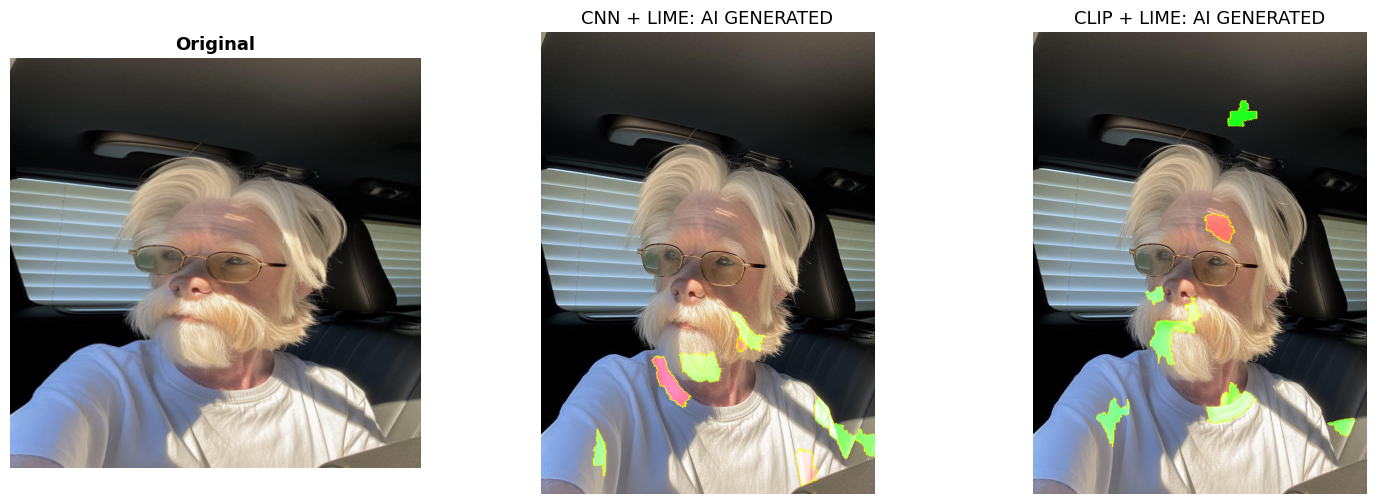

Saved to: gui_images/LIME/ai_generated/img1.png
CNN predicts:  AI GENERATED (klasse 0)
CLIP predicts AI GENERATED (klasse 0)


In [13]:
process_image_with_lime(1, ai=True)

In [ ]:
for i in range(2, 11):
    process_image_with_lime(i, ai=True)
    process_image_with_lime(i, ai=False)

Output hidden; open in https://colab.research.google.com to view.